# Import

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import cv2
import copy
import time
import geopandas as gpd
from tqdm import tqdm 
from tqdm.auto import tqdm
import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mpl_toolkits.mplot3d import Axes3D

ModuleNotFoundError: No module named 'geopandas'

# EDA

Total data awal: 23784


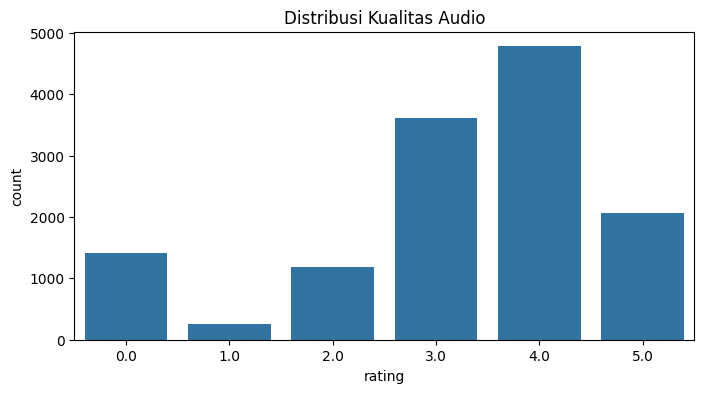

20 Burung dengan data terbanyak:
primary_label
Loxia curvirostra_Red Crossbill                 1101
Passer domesticus_House Sparrow                  958
Troglodytes aedon_House Wren                     860
Corvus corax_Northern Raven                      756
Sturnus vulgaris_Common Starling                 590
Hirundo rustica_Barn Swallow                     510
Melospiza melodia_Song Sparrow                   499
Agelaius phoeniceus_Red-winged Blackbird         387
Cardinalis cardinalis_Northern Cardinal          376
Pipilo maculatus_Spotted Towhee                  356
Anas platyrhynchos_Mallard                       345
Turdus migratorius_American Robin                324
Thryothorus ludovicianus_Carolina Wren           306
Thryomanes bewickii_Bewick's Wren                299
Streptopelia decaocto_Eurasian Collared Dove     266
Catharus ustulatus_Swainson's Thrush             264
Geothlypis trichas_Common Yellowthroat           257
Vireo gilvus_Warbling Vireo                      208

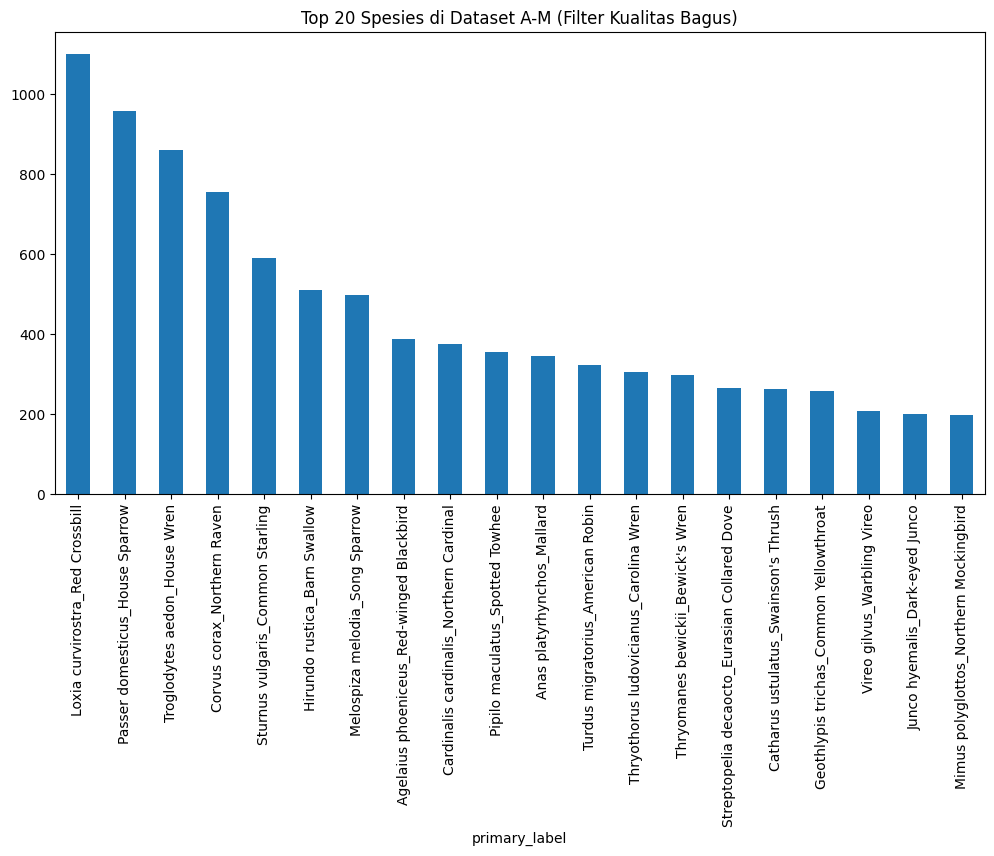

In [ ]:
df = pd.read_csv('train_extended.csv') 

# 2. Filter Awal (Hanya Spesies A-M)
print(f"Total data awal: {len(df)}")

# 3. Cek Distribusi Kualitas
# Xeno-canto punya rating: 'A' (Bagus) sampai 'E' (Jelek)
plt.figure(figsize=(8,4))
sns.countplot(x='rating', data=df, order=['0.0', '1.0', '2.0', '3.0', '4.0', '5.0']) 
plt.title("Distribusi Kualitas Audio")
plt.show()

# 4. Filter "Data Bersih"
df_clean = df[df['rating'] >= 3.0] 

# 5. Cek Top 20 Spesies Terbanyak
top_birds = df_clean['primary_label'].value_counts().head(20)
print("20 Burung dengan data terbanyak:")
print(top_birds)

plt.figure(figsize=(12,6))
top_birds.plot(kind='bar')
plt.title("Top 20 Spesies di Dataset A-M (Filter Kualitas Bagus)")
plt.show()

# Preprocessing

In [ ]:
PATH_AUDIO_ROOT = "./Dataset/" 
EXTENSIONS = ('.ogg', '.mp3', '.wav', '.flac')

print(f"Sedang men-scan folder: {PATH_AUDIO_ROOT} ...")

species_stats = []

# Ambil semua subfolder
if not os.path.exists(PATH_AUDIO_ROOT):
    print("Error: Folder Dataset tidak ditemukan!")
else:
    subfolders = [f for f in os.listdir(PATH_AUDIO_ROOT) if os.path.isdir(os.path.join(PATH_AUDIO_ROOT, f))]

    for folder_name in subfolders:
        folder_path = os.path.join(PATH_AUDIO_ROOT, folder_name)
        
        # Hitung jumlah file audio di dalamnya
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(EXTENSIONS)]
        count = len(files)
        
        if count > 0:
            species_stats.append({'ebird_code': folder_name, 'count': count})

    # 2. URUTKAN & AMBIL TOP 20
    df_stats = pd.DataFrame(species_stats)
    
    if df_stats.empty:
        print("Tidak ditemukan folder spesies dengan file audio!")
    else:
        # Urutkan dari yang terbanyak
        df_stats = df_stats.sort_values(by='count', ascending=False).reset_index(drop=True)
        
        # Coba pasangkan dengan Nama Lengkap dari CSV lama
        try:
            meta_df = pd.read_csv('metadata_20_spesies.csv')
            # Buat kamus: kode -> nama lengkap
            code_to_name = meta_df.drop_duplicates('ebird_code').set_index('ebird_code')['primary_label'].to_dict()
            df_stats['full_name'] = df_stats['ebird_code'].map(code_to_name)
        except:
            df_stats['full_name'] = "Info tidak ada di CSV"

        print("\nTOP 20 SPESIES TERBANYAK DI DATASET ANDA:")
        print("-" * 60)
        print(f"{'No':<4} {'Kode Folder':<15} {'Jumlah File':<12} {'Nama Spesies (Prediksi)'}")
        print("-" * 60)
        
        top_20 = df_stats.head(20)
        
        for idx, row in top_20.iterrows():
            nama = str(row['full_name']) if pd.notna(row['full_name']) else "(Nama tidak diketahui)"
            print(f"{idx+1:<4} {row['ebird_code']:<15} {row['count']:<12} {nama}")
            
        print("-" * 60)
        
        # 3. SIMPAN DAFTAR BARU INI
        top_20.to_csv('metadata_top20.csv', index=False)
        print("\nDaftar baru telah disimpan ke: 'metadata_top20.csv'")

📂 Sedang men-scan folder: ./Dataset/ ...

🏆 TOP 20 SPESIES TERBANYAK DI DATASET ANDA:
------------------------------------------------------------
No   Kode Folder     Jumlah File  Nama Spesies (Prediksi)
------------------------------------------------------------
1    houspa          1216         Passer domesticus_House Sparrow
2    houwre          984          Troglodytes aedon_House Wren
3    comrav          889          Corvus corax_Northern Raven
4    eursta          694          Sturnus vulgaris_Common Starling
5    barswa          608          Hirundo rustica_Barn Swallow
6    amerob          407          Turdus migratorius_American Robin
7    mallar3         407          Anas platyrhynchos_Mallard
8    carwre          371          Thryothorus ludovicianus_Carolina Wren
9    bewwre          363          Thryomanes bewickii_Bewick's Wren
10   eucdov          318          Streptopelia decaocto_Eurasian Collared Dove
11   comyel          307          Geothlypis trichas_Common Yell

In [ ]:
# --- 1. KONFIGURASI ---
INPUT_CSV = 'metadata_top20.csv'  
PATH_AUDIO_ROOT = "./Dataset/"        
OUTPUT_DIR = "dataset_spectrogram"    
SAMPLE_RATE = 32000
DURATION = 5                          
N_MELS = 128

# Kamus untuk memperbaiki nama yang "Unknown"
CODE_TO_NAME_FIX = {
    'marwre': 'Cistothorus palustris_Marsh Wren',
    'blujay': 'Cyanocitta cristata_Blue Jay',
    'grycat': 'Dumetella carolinensis_Grey Catbird',
    'comter': 'Sterna hirundo_Common Tern',
    'amered': 'Setophaga ruticilla_American Redstart',
    'grhowl': 'Bubo virginianus_Great Horned Owl',
    'bkcchi': 'Poecile atricapillus_Black-capped Chickadee',
    'houfin': 'Haemorhous mexicanus_House Finch',
    'houspa': 'Passer domesticus_House Sparrow',
    'houwre': 'Troglodytes aedon_House Wren',
    'comrav': 'Corvus corax_Northern Raven',
    'eursta': 'Sturnus vulgaris_Common Starling',
    'barswa': 'Hirundo rustica_Barn Swallow',
    'amerob': 'Turdus migratorius_American Robin',
    'mallar3': 'Anas platyrhynchos_Mallard',
    'carwre': 'Thryothorus ludovicianus_Carolina Wren',
    'bewwre': "Thryomanes bewickii_Bewick's Wren",
    'eucdov': 'Streptopelia decaocto_Eurasian Collared Dove',
    'comyel': 'Geothlypis trichas_Common Yellowthroat',
    'daejun': 'Junco hyemalis_Dark-eyed Junco'
}

# 2. PERSIAPAN DATA
df = pd.read_csv(INPUT_CSV)
print(f"Memuat {len(df)} folder spesies dari CSV...")

# Fungsi helper untuk mendapatkan nama folder output yang cantik
def get_folder_name(row):
    code = row['ebird_code']
    # Cek di kamus manual
    if code in CODE_TO_NAME_FIX:
        return CODE_TO_NAME_FIX[code]
    # Kalau tidak ada di kamus, pakai nama dari CSV
    elif pd.notna(row['full_name']) and row['full_name'] != "(Nama tidak diketahui)":
        return row['full_name']
    else:
        return code

# 3. FUNGSI KONVERSI UTAMA
def process_species_folder(row):
    species_code = row['ebird_code']
    target_folder_name = get_folder_name(row)
    
    source_folder = os.path.join(PATH_AUDIO_ROOT, species_code)
    dest_folder = os.path.join(OUTPUT_DIR, target_folder_name)
    
    # Buat folder tujuan
    os.makedirs(dest_folder, exist_ok=True)
    
    # Ambil semua file audio di folder tersebut
    if not os.path.exists(source_folder):
        return 0 # Folder asal gak ketemu (aneh, tapi jaga-jaga)
        
    audio_files = [f for f in os.listdir(source_folder) if f.endswith(('.mp3', '.ogg', '.wav', '.flac'))]
    
    success_count = 0
    
    # Loop convert setiap file
    for audio_file in tqdm(audio_files, desc=f"Processing {species_code}", leave=False):
        try:
            full_path = os.path.join(source_folder, audio_file)
            save_name = audio_file.replace('.mp3','.png').replace('.ogg','.png').replace('.wav','.png')
            save_path = os.path.join(dest_folder, save_name)
            
            # Skip jika gambar sudah ada (biar bisa lanjut kalau putus)
            if os.path.exists(save_path):
                success_count += 1
                continue

            y, sr = librosa.load(full_path, sr=SAMPLE_RATE, mono=True)
            y, _ = librosa.effects.trim(y, top_db=20)
            
            # Padding / Cutting
            target_len = SAMPLE_RATE * DURATION
            if len(y) < target_len:
                y = np.pad(y, (0, target_len - len(y)))
            else:
                y = y[:target_len]

            # Spectrogram
            melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, fmax=14000)
            melspec_db = librosa.power_to_db(melspec, ref=np.max)

            # Normalize to 0-255
            img = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min()) * 255.0
            img = img.astype(np.uint8)
            img = np.flip(img, axis=0) # Flip biar frekuensi rendah di bawah

            # Save
            cv2.imwrite(save_path, img)
            success_count += 1
            
        except Exception as e:
            continue # Skip file rusak
            
    return success_count

# 4. EKSEKUSI
print(f"Mulai Membuat Spectrogram untuk {len(df)} Spesies...")
print(f"Output Folder: {OUTPUT_DIR}")

total_images = 0
for index, row in df.iterrows():
    print(f"\n[{index+1}/{len(df)}] Memproses: {row['ebird_code']} -> {get_folder_name(row)}")
    count = process_species_folder(row)
    total_images += count
    print(f"   Selesai: {count} gambar.")

print(f"Total {total_images} Spectrogram berhasil dibuat.")
print("Sekarang dataset Anda sudah bersih, lengkap, dan siap 100% untuk Training.")

📂 Memuat 20 folder spesies dari CSV...
🚀 Mulai Membuat Spectrogram untuk 20 Spesies...
💾 Output Folder: dataset_spectrogram

[1/20] Memproses: houspa -> Passer domesticus_House Sparrow


   ✅ Selesai: 1216 gambar.

[2/20] Memproses: houwre -> Troglodytes aedon_House Wren


   ✅ Selesai: 984 gambar.

[3/20] Memproses: comrav -> Corvus corax_Northern Raven


   ✅ Selesai: 889 gambar.

[4/20] Memproses: eursta -> Sturnus vulgaris_Common Starling


   ✅ Selesai: 694 gambar.

[5/20] Memproses: barswa -> Hirundo rustica_Barn Swallow


   ✅ Selesai: 608 gambar.

[6/20] Memproses: amerob -> Turdus migratorius_American Robin


   ✅ Selesai: 407 gambar.

[7/20] Memproses: mallar3 -> Anas platyrhynchos_Mallard


   ✅ Selesai: 407 gambar.

[8/20] Memproses: carwre -> Thryothorus ludovicianus_Carolina Wren


   ✅ Selesai: 371 gambar.

[9/20] Memproses: bewwre -> Thryomanes bewickii_Bewick's Wren


   ✅ Selesai: 363 gambar.

[10/20] Memproses: eucdov -> Streptopelia decaocto_Eurasian Collared Dove


   ✅ Selesai: 318 gambar.

[11/20] Memproses: comyel -> Geothlypis trichas_Common Yellowthroat


   ✅ Selesai: 307 gambar.

[12/20] Memproses: daejun -> Junco hyemalis_Dark-eyed Junco


   ✅ Selesai: 257 gambar.

[13/20] Memproses: marwre -> Cistothorus palustris_Marsh Wren


   ✅ Selesai: 240 gambar.

[14/20] Memproses: blujay -> Cyanocitta cristata_Blue Jay


   ✅ Selesai: 239 gambar.

[15/20] Memproses: grycat -> Dumetella carolinensis_Grey Catbird


   ✅ Selesai: 235 gambar.

[16/20] Memproses: comter -> Sterna hirundo_Common Tern


   ✅ Selesai: 224 gambar.

[17/20] Memproses: amered -> Setophaga ruticilla_American Redstart


   ✅ Selesai: 198 gambar.

[18/20] Memproses: grhowl -> Bubo virginianus_Great Horned Owl


   ✅ Selesai: 194 gambar.

[19/20] Memproses: bkcchi -> Poecile atricapillus_Black-capped Chickadee


   ✅ Selesai: 188 gambar.

[20/20] Memproses: houfin -> Haemorhous mexicanus_House Finch


   ✅ Selesai: 187 gambar.

🎉 SUKSES BESAR! Total 8526 Spectrogram berhasil dibuat.
Sekarang dataset Anda sudah bersih, lengkap, dan siap 100% untuk Training.


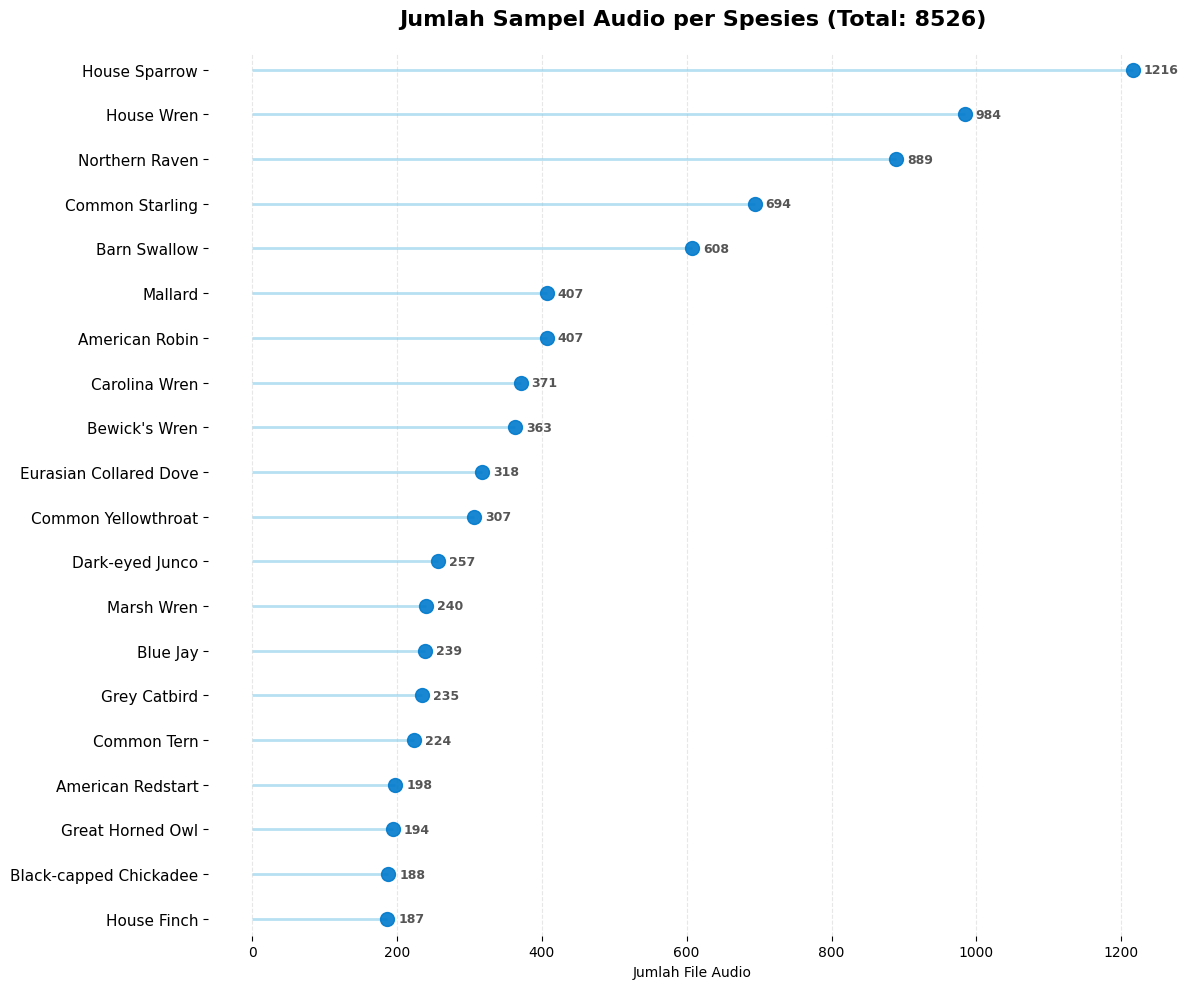

In [ ]:
# 1. Load Data
df = pd.read_csv('metadata_top20_FIX.csv')

name_map = {
    'marwre': 'Cistothorus palustris_Marsh Wren',
    'blujay': 'Cyanocitta cristata_Blue Jay',
    'grycat': 'Dumetella carolinensis_Grey Catbird',
    'comter': 'Sterna hirundo_Common Tern',
    'amered': 'Setophaga ruticilla_American Redstart',
    'grhowl': 'Bubo virginianus_Great Horned Owl',
    'bkcchi': 'Poecile atricapillus_Black-capped Chickadee',
    'houfin': 'Haemorhous mexicanus_House Finch'
}

# Jika kode ebird ada di map, pakai nama baru. Jika tidak, pakai nama lama.
df['full_name'] = df.apply(lambda row: name_map.get(row['ebird_code'], row['full_name']), axis=1)

# Sortir dari jumlah terkecil ke terbesar untuk plotting
df_sorted = df.sort_values('count', ascending=True)

# Ambil Label dan Values 
# Kita ambil kata terakhir setelah '_' (misal: "House Wren")
labels = [str(label).split('_')[-1] for label in df_sorted['full_name']]
values = df_sorted['count'].values

# PLOTTING
plt.figure(figsize=(12, 10))
plt.hlines(y=range(len(labels)), xmin=0, xmax=values, color='skyblue', alpha=0.6, linewidth=2)
plt.plot(values, range(len(labels)), "o", markersize=10, color='#007ACC', alpha=0.9)
for x, y, val in zip(values, range(len(labels)), values):
    plt.text(x + 15, y, str(val), va='center', fontsize=9, color='#555555', fontweight='bold')
plt.yticks(range(len(labels)), labels, fontsize=11)
plt.title(f"Jumlah Sampel Audio per Spesies (Total: {sum(values)})", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Jumlah File Audio")
plt.box(False)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.margins(y=0.02) # Memberi sedikit jarak di atas/bawah
plt.tight_layout()
plt.show()

🌍 Sedang mengunduh data peta dunia (Natural Earth)...
✅ Peta dunia berhasil dimuat!


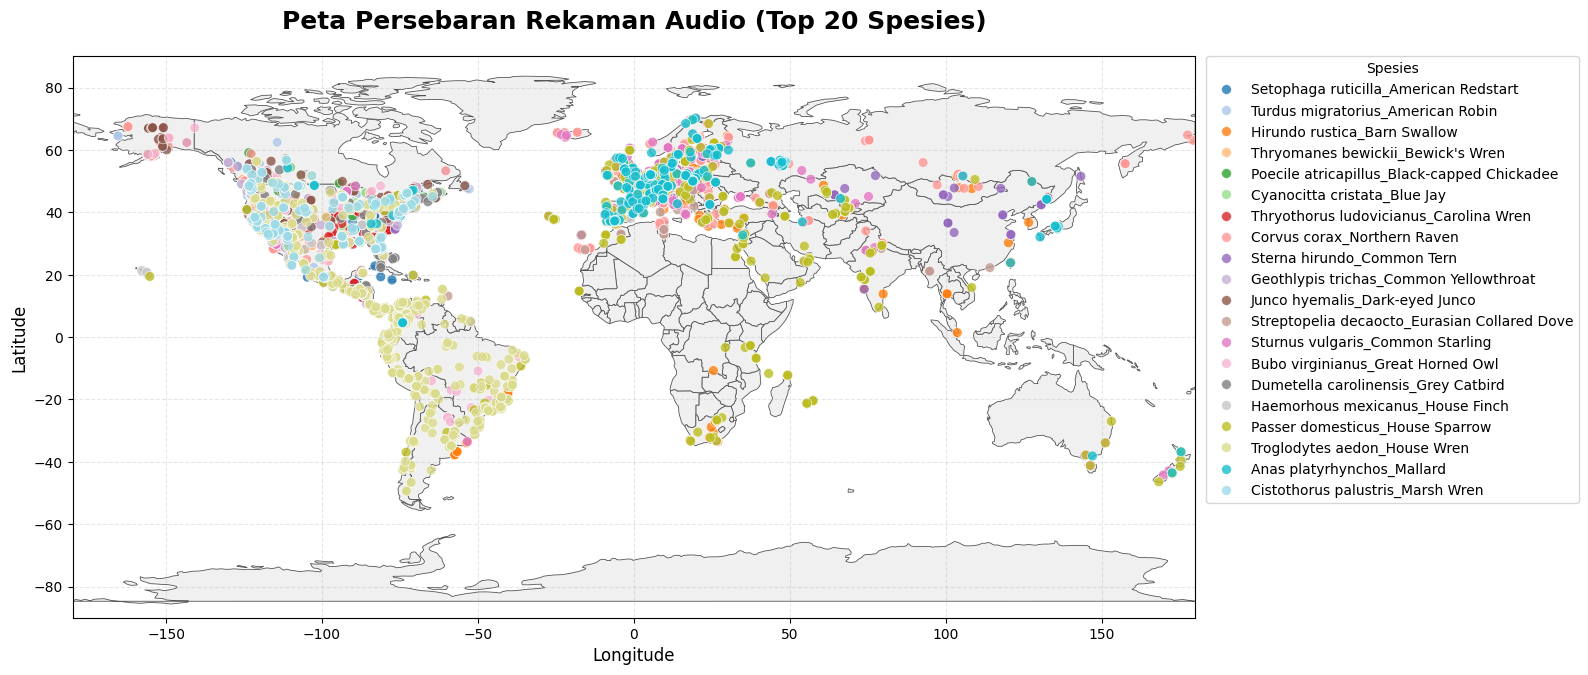

In [ ]:
# 1. Load Data
df_meta = pd.read_csv('train_extended.csv') 
df_top20 = pd.read_csv('metadata_top20_FIX.csv')

# 2. Filter & Bersihkan Data
valid_codes = df_top20['ebird_code'].unique()
df_final = df_meta[df_meta['ebird_code'].isin(valid_codes)].copy()
df_final = df_final.dropna(subset=['latitude', 'longitude'])
df_final['longitude'] = pd.to_numeric(df_final['longitude'], errors='coerce')
df_final['latitude'] = pd.to_numeric(df_final['latitude'], errors='coerce')

# 3. Setup Plot
fig, ax = plt.subplots(figsize=(16, 10))

try:
    print("Sedang mengunduh data peta dunia")
    # URL langsung ke file GeoJSON peta dunia (Stabil)
    map_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
    world = gpd.read_file(map_url)
    world.plot(
        ax=ax, 
        color='#f0f0f0',     
        edgecolor='#555555', 
        linewidth=0.6
    )
    
except Exception as e:
    print(f"Gagal memuat peta dari internet: {e}")
    print("Pastikan komputer Anda terkoneksi internet.")

# 4. Gambar Scatterplot di atas Peta
sns.scatterplot(
    data=df_final, 
    x='longitude', 
    y='latitude', 
    hue='primary_label', 
    palette='tab20',     
    alpha=0.8,            
    s=50,                 
    edgecolor='w',        
    linewidth=0.5,
    ax=ax                 
)

# 5. Hiasan & Limitasi Area
ax.set_title('Peta Persebaran Rekaman Audio (Top 20 Spesies)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, title='Spesies', fontsize=10)
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Berhasil menemukan file acak: ./Dataset\eastow\XC568486.mp3
Sedang memproses visualisasi 3D... Mohon tunggu sebentar.


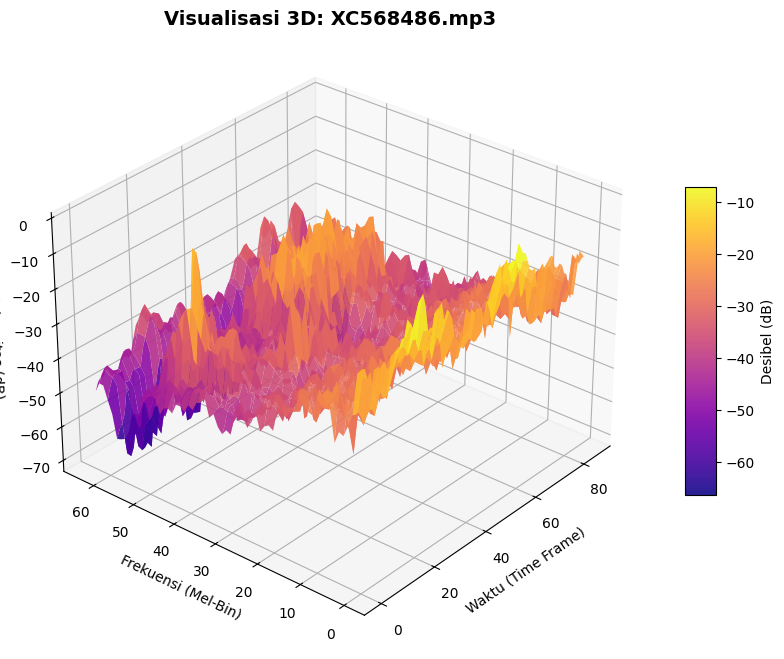

In [ ]:
# --- KONFIGURASI PENTING ---
FOLDER_DATASET = "./Dataset"  

def get_random_audio_file(root_folder):
    audio_files = []
    # Jalan-jalan ke semua sub-folder untuk cari file audio
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Cari yang akhiran .ogg atau .mp3
            if file.lower().endswith(('.ogg', '.mp3', '.wav')):
                audio_files.append(os.path.join(root, file))
    
    if not audio_files:
        raise FileNotFoundError(f"Tidak ada file audio (.ogg/.mp3) ditemukan di folder: {root_folder}")

    return random.choice(audio_files)

try:
    # 1. Cari file random
    file_audio_acak = get_random_audio_file(FOLDER_DATASET)
    print(f"Berhasil menemukan file acak: {file_audio_acak}")
    print("Sedang memproses visualisasi 3D... Mohon tunggu sebentar.")

    y, sr = librosa.load(file_audio_acak, duration=3)
    
    # 3. Buat Mel Spectrogram
    spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64) 
    spec_db = librosa.power_to_db(spec, ref=np.max)

    # 4. Persiapan Plot 3D
    X, Y = np.meshgrid(np.arange(spec_db.shape[1]), np.arange(spec_db.shape[0]))

    # 5. Gambar Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface Plot dengan warna 'plasma'
    surf = ax.plot_surface(X, Y, spec_db, cmap='plasma', edgecolor='none', alpha=0.9)

    # Atur sudut pandang biar terlihat keren (Isometrik)
    ax.view_init(elev=30, azim=220)

    ax.set_xlabel('Waktu (Time Frame)')
    ax.set_ylabel('Frekuensi (Mel-Bin)')
    ax.set_zlabel('Intensitas (dB)')
    
    # Judul mengambil nama file biar ketahuan file apa yang muncul
    nama_file = os.path.basename(file_audio_acak)
    plt.title(f"Visualisasi 3D: {nama_file}", fontsize=14, fontweight='bold')
    plt.colorbar(surf, shrink=0.5, aspect=10, label='Desibel (dB)')
    plt.show()

except FileNotFoundError as e:
    print("\nKESALAHAN PATH:")
    print(e)
    print("Saran: Cek lagi variabel 'FOLDER_DATASET' di bagian paling atas kode.")
except Exception as e:
    print(f"Terjadi error lain: {e}")

In [ ]:
# Konfigurasi
input_folder = "dataset_spectrogram"
output_folder = "dataset_for_training"

# Cek folder dulu
if not os.path.exists(input_folder):
    print("Folder input tidak ditemukan!")
else:
    print("Sedang membagi data menjadi 80% Train dan 20% Val...")
    
    # Split dengan seed=42 agar hasilnya tetap sama kalau diulang
    splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None, move=False)
    
    print("Selesai! Cek folder:", output_folder)
    print("Struktur folder sekarang:")
    print(f"   ├── {output_folder}/train (Untuk train)")
    print(f"   └── {output_folder}/val   (Untuk validasi)")

Sedang membagi data menjadi 80% Train dan 20% Val...


Copying files: 8526 files [01:50, 76.99 files/s]

Selesai! Cek folder: dataset_for_training
Struktur folder sekarang:
   ├── dataset_for_training/train (Untuk belajar)
   └── dataset_for_training/val   (Untuk ujian)


# Model

In [ ]:
# 1. FOCAL LOSS
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

DATA_DIR = 'dataset_for_training'
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 100        
PATIENCE = 10      
NUM_CLASSES = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {DEVICE}")
print(f"Training maksimal {EPOCHS} Epoch dengan MixUp + Pure Focal Loss")

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.15))
    ]),
    'val': transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_ftrs, NUM_CLASSES)
)
model = model.to(DEVICE)

# Focal Loss
criterion = FocalLoss(alpha=None, gamma=2.0)

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# 5. Training Loop dengna mixup augmentasi
def train_model(model, criterion, optimizer, num_epochs=25, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_acc = 0.0
    patience_counter = 0
    
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase}"):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # mixup augmentasi
                    if phase == 'train':
                        # 1. Generate Lambda (Rasio campuran, misal 0.7)
                        # Beta(1.0, 1.0) menghasilkan distribusi uniform
                        lam = np.random.beta(1.0, 1.0)
                        
                        # 2. Acak Index
                        index = torch.randperm(inputs.size(0)).to(DEVICE)
                        
                        # 3. Campur Gambar (Mix Images)
                        mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
                        
                        # 4. Siapkan Label Pasangan
                        labels_a, labels_b = labels, labels[index]
                        
                        # 5. Forward Pass dengan Gambar Campuran
                        outputs = model(mixed_inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        # 6. Hitung Loss Campuran (Mix Loss)
                        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
                        
                        loss.backward()
                        optimizer.step()
                        
                        # Hitung Akurasi "Soft" untuk monitoring
                        # Kita hitung berapa persen prediksi cocok dengan A atau B
                        corrects_soft = (lam * (preds == labels_a).float() + (1 - lam) * (preds == labels_b).float()).sum()
                        running_corrects += corrects_soft
                        
                    else:
                        # Validasi tanpa mixup augmentasi
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        running_corrects += torch.sum(preds == labels.data)

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if isinstance(epoch_acc, torch.Tensor):
                epoch_acc = epoch_acc.item()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            else:
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)

                # Early Stopping Logic (Berdasarkan Val Loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc 
                    best_model_wts = copy.deepcopy(model.state_dict()) 
                    patience_counter = 0 
                    print(f"Model membaik! Saving checkpoint... (Loss: {best_loss:.4f})")
                else:
                    patience_counter += 1
                    print(f"Tidak ada perbaikan Loss. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly Stopping Triggered! Berhenti di Epoch {epoch+1}")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining selesai dalam {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Loss Terbaik: {best_loss:.4f}, Akurasi Saat Itu: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history


Menggunakan device: cuda
Training maksimal 100 Epoch dengan MixUp + Pure Focal Loss


In [ ]:
trained_model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS, patience=PATIENCE)

SAVE_PATH = 'model_effecientnet_final.pth'
torch.save(trained_model.state_dict(), SAVE_PATH)
print(f"Model Focal Loss disimpan ke: {SAVE_PATH}")


Epoch 1/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.14it/s]


train Loss: 2.3719 Acc: 0.1908


val: 100%|██████████| 54/54 [00:06<00:00,  8.04it/s]


val Loss: 1.8380 Acc: 0.3806
✅ Model membaik! Saving checkpoint... (Loss: 1.8380)

Epoch 2/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.99it/s]


train Loss: 1.9360 Acc: 0.3278


val: 100%|██████████| 54/54 [00:06<00:00,  8.34it/s]


val Loss: 1.3848 Acc: 0.4851
✅ Model membaik! Saving checkpoint... (Loss: 1.3848)

Epoch 3/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 14.14it/s]


train Loss: 1.6869 Acc: 0.4112


val: 100%|██████████| 54/54 [00:06<00:00,  8.00it/s]


val Loss: 1.1139 Acc: 0.5820
✅ Model membaik! Saving checkpoint... (Loss: 1.1139)

Epoch 4/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.78it/s]


train Loss: 1.5444 Acc: 0.4608


val: 100%|██████████| 54/54 [00:06<00:00,  7.90it/s]


val Loss: 0.9576 Acc: 0.6351
✅ Model membaik! Saving checkpoint... (Loss: 0.9576)

Epoch 5/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.85it/s]


train Loss: 1.4363 Acc: 0.4982


val: 100%|██████████| 54/54 [00:06<00:00,  7.86it/s]


val Loss: 0.8605 Acc: 0.6760
✅ Model membaik! Saving checkpoint... (Loss: 0.8605)

Epoch 6/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.31it/s]


train Loss: 1.3499 Acc: 0.5314


val: 100%|██████████| 54/54 [00:07<00:00,  7.53it/s]


val Loss: 0.8057 Acc: 0.6900
✅ Model membaik! Saving checkpoint... (Loss: 0.8057)

Epoch 7/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.74it/s]


train Loss: 1.3187 Acc: 0.5427


val: 100%|██████████| 54/54 [00:06<00:00,  7.76it/s]


val Loss: 0.7655 Acc: 0.7058
✅ Model membaik! Saving checkpoint... (Loss: 0.7655)

Epoch 8/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.83it/s]


train Loss: 1.2440 Acc: 0.5730


val: 100%|██████████| 54/54 [00:06<00:00,  7.75it/s]


val Loss: 0.7392 Acc: 0.7122
✅ Model membaik! Saving checkpoint... (Loss: 0.7392)

Epoch 9/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.26it/s]


train Loss: 1.1644 Acc: 0.6014


val: 100%|██████████| 54/54 [00:06<00:00,  8.00it/s]


val Loss: 0.6804 Acc: 0.7315
✅ Model membaik! Saving checkpoint... (Loss: 0.6804)

Epoch 10/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.10it/s]


train Loss: 1.1606 Acc: 0.5995


val: 100%|██████████| 54/54 [00:07<00:00,  7.32it/s]


val Loss: 0.6712 Acc: 0.7455
✅ Model membaik! Saving checkpoint... (Loss: 0.6712)

Epoch 11/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.82it/s]


train Loss: 1.1437 Acc: 0.6052


val: 100%|██████████| 54/54 [00:06<00:00,  8.14it/s]


val Loss: 0.6326 Acc: 0.7507
✅ Model membaik! Saving checkpoint... (Loss: 0.6326)

Epoch 12/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.07it/s]


train Loss: 1.0644 Acc: 0.6255


val: 100%|██████████| 54/54 [00:06<00:00,  7.80it/s]


val Loss: 0.6253 Acc: 0.7583
✅ Model membaik! Saving checkpoint... (Loss: 0.6253)

Epoch 13/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.37it/s]


train Loss: 1.0947 Acc: 0.6239


val: 100%|██████████| 54/54 [00:06<00:00,  7.88it/s]


val Loss: 0.6204 Acc: 0.7501
✅ Model membaik! Saving checkpoint... (Loss: 0.6204)

Epoch 14/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.64it/s]


train Loss: 0.9890 Acc: 0.6690


val: 100%|██████████| 54/54 [00:07<00:00,  6.85it/s]


val Loss: 0.6147 Acc: 0.7583
✅ Model membaik! Saving checkpoint... (Loss: 0.6147)

Epoch 15/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.87it/s]


train Loss: 1.0336 Acc: 0.6518


val: 100%|██████████| 54/54 [00:07<00:00,  7.41it/s]


val Loss: 0.6071 Acc: 0.7583
✅ Model membaik! Saving checkpoint... (Loss: 0.6071)

Epoch 16/100
----------


train: 100%|██████████| 213/213 [00:17<00:00, 12.47it/s]


train Loss: 1.0016 Acc: 0.6563


val: 100%|██████████| 54/54 [00:06<00:00,  7.79it/s]


val Loss: 0.6207 Acc: 0.7525
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 17/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.73it/s]


train Loss: 0.9858 Acc: 0.6652


val: 100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


val Loss: 0.5976 Acc: 0.7589
✅ Model membaik! Saving checkpoint... (Loss: 0.5976)

Epoch 18/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.12it/s]


train Loss: 0.9992 Acc: 0.6595


val: 100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


val Loss: 0.6212 Acc: 0.7566
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 19/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.42it/s]


train Loss: 0.9317 Acc: 0.6811


val: 100%|██████████| 54/54 [00:07<00:00,  7.30it/s]


val Loss: 0.5903 Acc: 0.7601
✅ Model membaik! Saving checkpoint... (Loss: 0.5903)

Epoch 20/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.83it/s]


train Loss: 0.9537 Acc: 0.6748


val: 100%|██████████| 54/54 [00:07<00:00,  7.45it/s]


val Loss: 0.5881 Acc: 0.7647
✅ Model membaik! Saving checkpoint... (Loss: 0.5881)

Epoch 21/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.23it/s]


train Loss: 0.9456 Acc: 0.6831


val: 100%|██████████| 54/54 [00:07<00:00,  7.71it/s]


val Loss: 0.5683 Acc: 0.7770
✅ Model membaik! Saving checkpoint... (Loss: 0.5683)

Epoch 22/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.06it/s]


train Loss: 1.0184 Acc: 0.6478


val: 100%|██████████| 54/54 [00:06<00:00,  7.72it/s]


val Loss: 0.5989 Acc: 0.7682
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 23/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.25it/s]


train Loss: 0.9319 Acc: 0.6793


val: 100%|██████████| 54/54 [00:07<00:00,  7.57it/s]


val Loss: 0.5850 Acc: 0.7653
⚠️ Tidak ada perbaikan Loss. Patience: 2/10

Epoch 24/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.32it/s]


train Loss: 0.9288 Acc: 0.6834


val: 100%|██████████| 54/54 [00:07<00:00,  7.25it/s]


val Loss: 0.5804 Acc: 0.7852
⚠️ Tidak ada perbaikan Loss. Patience: 3/10

Epoch 25/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.05it/s]


train Loss: 0.9007 Acc: 0.6871


val: 100%|██████████| 54/54 [00:06<00:00,  7.73it/s]


val Loss: 0.5878 Acc: 0.7688
⚠️ Tidak ada perbaikan Loss. Patience: 4/10

Epoch 26/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.23it/s]


train Loss: 0.8916 Acc: 0.6937


val: 100%|██████████| 54/54 [00:06<00:00,  7.87it/s]


val Loss: 0.5919 Acc: 0.7717
⚠️ Tidak ada perbaikan Loss. Patience: 5/10

Epoch 27/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.20it/s]


train Loss: 0.8672 Acc: 0.7065


val: 100%|██████████| 54/54 [00:06<00:00,  7.88it/s]


val Loss: 0.5770 Acc: 0.7823
⚠️ Tidak ada perbaikan Loss. Patience: 6/10

Epoch 28/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.44it/s]


train Loss: 0.9178 Acc: 0.6833


val: 100%|██████████| 54/54 [00:06<00:00,  7.74it/s]


val Loss: 0.5665 Acc: 0.7852
✅ Model membaik! Saving checkpoint... (Loss: 0.5665)

Epoch 29/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.35it/s]


train Loss: 0.8903 Acc: 0.6902


val: 100%|██████████| 54/54 [00:08<00:00,  6.46it/s]


val Loss: 0.5755 Acc: 0.7840
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 30/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.11it/s]


train Loss: 0.8203 Acc: 0.7284


val: 100%|██████████| 54/54 [00:07<00:00,  7.09it/s]


val Loss: 0.5542 Acc: 0.7916
✅ Model membaik! Saving checkpoint... (Loss: 0.5542)

Epoch 31/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.11it/s]


train Loss: 0.8705 Acc: 0.7003


val: 100%|██████████| 54/54 [00:06<00:00,  8.05it/s]


val Loss: 0.5509 Acc: 0.7782
✅ Model membaik! Saving checkpoint... (Loss: 0.5509)

Epoch 32/100
----------


train: 100%|██████████| 213/213 [00:17<00:00, 11.99it/s]


train Loss: 0.8784 Acc: 0.6976


val: 100%|██████████| 54/54 [00:06<00:00,  7.75it/s]


val Loss: 0.5574 Acc: 0.7852
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 33/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.63it/s]


train Loss: 0.9050 Acc: 0.6839


val: 100%|██████████| 54/54 [00:07<00:00,  7.69it/s]


val Loss: 0.5669 Acc: 0.7846
⚠️ Tidak ada perbaikan Loss. Patience: 2/10

Epoch 34/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.01it/s]


train Loss: 0.8132 Acc: 0.7229


val: 100%|██████████| 54/54 [00:11<00:00,  4.80it/s]


val Loss: 0.5553 Acc: 0.7922
⚠️ Tidak ada perbaikan Loss. Patience: 3/10

Epoch 35/100
----------


train: 100%|██████████| 213/213 [00:22<00:00,  9.67it/s]


train Loss: 0.8566 Acc: 0.7073


val: 100%|██████████| 54/54 [00:07<00:00,  7.45it/s]


val Loss: 0.5631 Acc: 0.7904
⚠️ Tidak ada perbaikan Loss. Patience: 4/10

Epoch 36/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.28it/s]


train Loss: 0.7856 Acc: 0.7357


val: 100%|██████████| 54/54 [00:06<00:00,  7.76it/s]


val Loss: 0.5742 Acc: 0.7863
⚠️ Tidak ada perbaikan Loss. Patience: 5/10

Epoch 37/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.75it/s]


train Loss: 0.8082 Acc: 0.7203


val: 100%|██████████| 54/54 [00:06<00:00,  7.91it/s]


val Loss: 0.5521 Acc: 0.7928
⚠️ Tidak ada perbaikan Loss. Patience: 6/10

Epoch 38/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.34it/s]


train Loss: 0.8189 Acc: 0.7197


val: 100%|██████████| 54/54 [00:07<00:00,  7.50it/s]


val Loss: 0.5614 Acc: 0.7910
⚠️ Tidak ada perbaikan Loss. Patience: 7/10

Epoch 39/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.45it/s]


train Loss: 0.8329 Acc: 0.7095


val: 100%|██████████| 54/54 [00:07<00:00,  7.25it/s]


val Loss: 0.5875 Acc: 0.7793
⚠️ Tidak ada perbaikan Loss. Patience: 8/10

Epoch 40/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.14it/s]


train Loss: 0.7962 Acc: 0.7243


val: 100%|██████████| 54/54 [00:07<00:00,  7.67it/s]


val Loss: 0.5911 Acc: 0.7793
⚠️ Tidak ada perbaikan Loss. Patience: 9/10

Epoch 41/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 12.80it/s]


train Loss: 0.7892 Acc: 0.7250


val: 100%|██████████| 54/54 [00:06<00:00,  7.74it/s]


val Loss: 0.5497 Acc: 0.7858
✅ Model membaik! Saving checkpoint... (Loss: 0.5497)

Epoch 42/100
----------


train: 100%|██████████| 213/213 [00:17<00:00, 11.91it/s]


train Loss: 0.8048 Acc: 0.7148


val: 100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


val Loss: 0.5492 Acc: 0.7858
✅ Model membaik! Saving checkpoint... (Loss: 0.5492)

Epoch 43/100
----------


train: 100%|██████████| 213/213 [00:27<00:00,  7.63it/s]


train Loss: 0.8206 Acc: 0.7075


val: 100%|██████████| 54/54 [00:15<00:00,  3.57it/s]


val Loss: 0.5552 Acc: 0.7869
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 44/100
----------


train: 100%|██████████| 213/213 [00:28<00:00,  7.41it/s]


train Loss: 0.7656 Acc: 0.7373


val: 100%|██████████| 54/54 [00:15<00:00,  3.48it/s]


val Loss: 0.5472 Acc: 0.7945
✅ Model membaik! Saving checkpoint... (Loss: 0.5472)

Epoch 45/100
----------


train: 100%|██████████| 213/213 [00:28<00:00,  7.40it/s]


train Loss: 0.7863 Acc: 0.7225


val: 100%|██████████| 54/54 [00:13<00:00,  3.86it/s]


val Loss: 0.5360 Acc: 0.7916
✅ Model membaik! Saving checkpoint... (Loss: 0.5360)

Epoch 46/100
----------


train: 100%|██████████| 213/213 [00:27<00:00,  7.86it/s]


train Loss: 0.7897 Acc: 0.7264


val: 100%|██████████| 54/54 [00:15<00:00,  3.59it/s]


val Loss: 0.5440 Acc: 0.7968
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 47/100
----------


train: 100%|██████████| 213/213 [00:25<00:00,  8.41it/s]


train Loss: 0.7588 Acc: 0.7372


val: 100%|██████████| 54/54 [00:13<00:00,  4.10it/s]


val Loss: 0.5385 Acc: 0.7933
⚠️ Tidak ada perbaikan Loss. Patience: 2/10

Epoch 48/100
----------


train: 100%|██████████| 213/213 [00:26<00:00,  7.92it/s]


train Loss: 0.7982 Acc: 0.7203


val: 100%|██████████| 54/54 [00:13<00:00,  3.88it/s]


val Loss: 0.5653 Acc: 0.7858
⚠️ Tidak ada perbaikan Loss. Patience: 3/10

Epoch 49/100
----------


train: 100%|██████████| 213/213 [00:26<00:00,  7.92it/s]


train Loss: 0.8034 Acc: 0.7177


val: 100%|██████████| 54/54 [00:16<00:00,  3.32it/s]


val Loss: 0.5589 Acc: 0.7863
⚠️ Tidak ada perbaikan Loss. Patience: 4/10

Epoch 50/100
----------


train: 100%|██████████| 213/213 [00:24<00:00,  8.72it/s]


train Loss: 0.8011 Acc: 0.7026


val: 100%|██████████| 54/54 [00:13<00:00,  4.11it/s]


val Loss: 0.5521 Acc: 0.7974
⚠️ Tidak ada perbaikan Loss. Patience: 5/10

Epoch 51/100
----------


train: 100%|██████████| 213/213 [00:28<00:00,  7.51it/s]


train Loss: 0.7982 Acc: 0.7164


val: 100%|██████████| 54/54 [00:14<00:00,  3.70it/s]


val Loss: 0.5360 Acc: 0.7957
✅ Model membaik! Saving checkpoint... (Loss: 0.5360)

Epoch 52/100
----------


train: 100%|██████████| 213/213 [00:26<00:00,  7.98it/s]


train Loss: 0.7770 Acc: 0.7209


val: 100%|██████████| 54/54 [00:15<00:00,  3.47it/s]


val Loss: 0.5434 Acc: 0.7910
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 53/100
----------


train: 100%|██████████| 213/213 [00:26<00:00,  8.02it/s]


train Loss: 0.8209 Acc: 0.7015


val: 100%|██████████| 54/54 [00:12<00:00,  4.24it/s]


val Loss: 0.5465 Acc: 0.7974
⚠️ Tidak ada perbaikan Loss. Patience: 2/10

Epoch 54/100
----------


train: 100%|██████████| 213/213 [00:28<00:00,  7.54it/s]


train Loss: 0.7571 Acc: 0.7280


val: 100%|██████████| 54/54 [00:13<00:00,  3.99it/s]


val Loss: 0.5328 Acc: 0.7928
✅ Model membaik! Saving checkpoint... (Loss: 0.5328)

Epoch 55/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.14it/s]


train Loss: 0.7768 Acc: 0.7231


val: 100%|██████████| 54/54 [00:07<00:00,  7.25it/s]


val Loss: 0.5554 Acc: 0.7922
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 56/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.38it/s]


train Loss: 0.7645 Acc: 0.7212


val: 100%|██████████| 54/54 [00:06<00:00,  8.20it/s]


val Loss: 0.5306 Acc: 0.7986
✅ Model membaik! Saving checkpoint... (Loss: 0.5306)

Epoch 57/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.24it/s]


train Loss: 0.7136 Acc: 0.7448


val: 100%|██████████| 54/54 [00:06<00:00,  7.95it/s]


val Loss: 0.5280 Acc: 0.8027
✅ Model membaik! Saving checkpoint... (Loss: 0.5280)

Epoch 58/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.91it/s]


train Loss: 0.7701 Acc: 0.7207


val: 100%|██████████| 54/54 [00:06<00:00,  8.10it/s]


val Loss: 0.5282 Acc: 0.8009
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 59/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.68it/s]


train Loss: 0.7506 Acc: 0.7229


val: 100%|██████████| 54/54 [00:06<00:00,  7.97it/s]


val Loss: 0.5404 Acc: 0.7945
⚠️ Tidak ada perbaikan Loss. Patience: 2/10

Epoch 60/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.73it/s]


train Loss: 0.7378 Acc: 0.7317


val: 100%|██████████| 54/54 [00:06<00:00,  8.13it/s]


val Loss: 0.5138 Acc: 0.8091
✅ Model membaik! Saving checkpoint... (Loss: 0.5138)

Epoch 61/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.00it/s]


train Loss: 0.7368 Acc: 0.7348


val: 100%|██████████| 54/54 [00:06<00:00,  8.09it/s]


val Loss: 0.5411 Acc: 0.8021
⚠️ Tidak ada perbaikan Loss. Patience: 1/10

Epoch 62/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.42it/s]


train Loss: 0.7587 Acc: 0.7103


val: 100%|██████████| 54/54 [00:06<00:00,  7.76it/s]


val Loss: 0.5549 Acc: 0.7980
⚠️ Tidak ada perbaikan Loss. Patience: 2/10

Epoch 63/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.47it/s]


train Loss: 0.7104 Acc: 0.7506


val: 100%|██████████| 54/54 [00:06<00:00,  7.82it/s]


val Loss: 0.5212 Acc: 0.8021
⚠️ Tidak ada perbaikan Loss. Patience: 3/10

Epoch 64/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.65it/s]


train Loss: 0.7273 Acc: 0.7297


val: 100%|██████████| 54/54 [00:06<00:00,  7.99it/s]


val Loss: 0.5379 Acc: 0.7986
⚠️ Tidak ada perbaikan Loss. Patience: 4/10

Epoch 65/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.25it/s]


train Loss: 0.7108 Acc: 0.7453


val: 100%|██████████| 54/54 [00:07<00:00,  7.36it/s]


val Loss: 0.5432 Acc: 0.7928
⚠️ Tidak ada perbaikan Loss. Patience: 5/10

Epoch 66/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.57it/s]


train Loss: 0.7137 Acc: 0.7439


val: 100%|██████████| 54/54 [00:07<00:00,  7.65it/s]


val Loss: 0.5277 Acc: 0.7980
⚠️ Tidak ada perbaikan Loss. Patience: 6/10

Epoch 67/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.41it/s]


train Loss: 0.7514 Acc: 0.7147


val: 100%|██████████| 54/54 [00:06<00:00,  7.78it/s]


val Loss: 0.5253 Acc: 0.8009
⚠️ Tidak ada perbaikan Loss. Patience: 7/10

Epoch 68/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.29it/s]


train Loss: 0.7234 Acc: 0.7301


val: 100%|██████████| 54/54 [00:06<00:00,  8.09it/s]


val Loss: 0.5404 Acc: 0.7974
⚠️ Tidak ada perbaikan Loss. Patience: 8/10

Epoch 69/100
----------


train: 100%|██████████| 213/213 [00:15<00:00, 13.33it/s]


train Loss: 0.7043 Acc: 0.7413


val: 100%|██████████| 54/54 [00:06<00:00,  7.88it/s]


val Loss: 0.5507 Acc: 0.7951
⚠️ Tidak ada perbaikan Loss. Patience: 9/10

Epoch 70/100
----------


train: 100%|██████████| 213/213 [00:16<00:00, 13.02it/s]


train Loss: 0.6945 Acc: 0.7495


val: 100%|██████████| 54/54 [00:07<00:00,  7.67it/s]

val Loss: 0.5231 Acc: 0.8009
⚠️ Tidak ada perbaikan Loss. Patience: 10/10

⏹️ Early Stopping Triggered! Berhenti di Epoch 70

Training selesai dalam 30m 58s
Loss Terbaik: 0.5138, Akurasi Saat Itu: 0.8091
💾 Model Focal Loss disimpan ke: model_effecientnet3_mixupAug_focalloss.pth


Menampilkan Grafik Training...


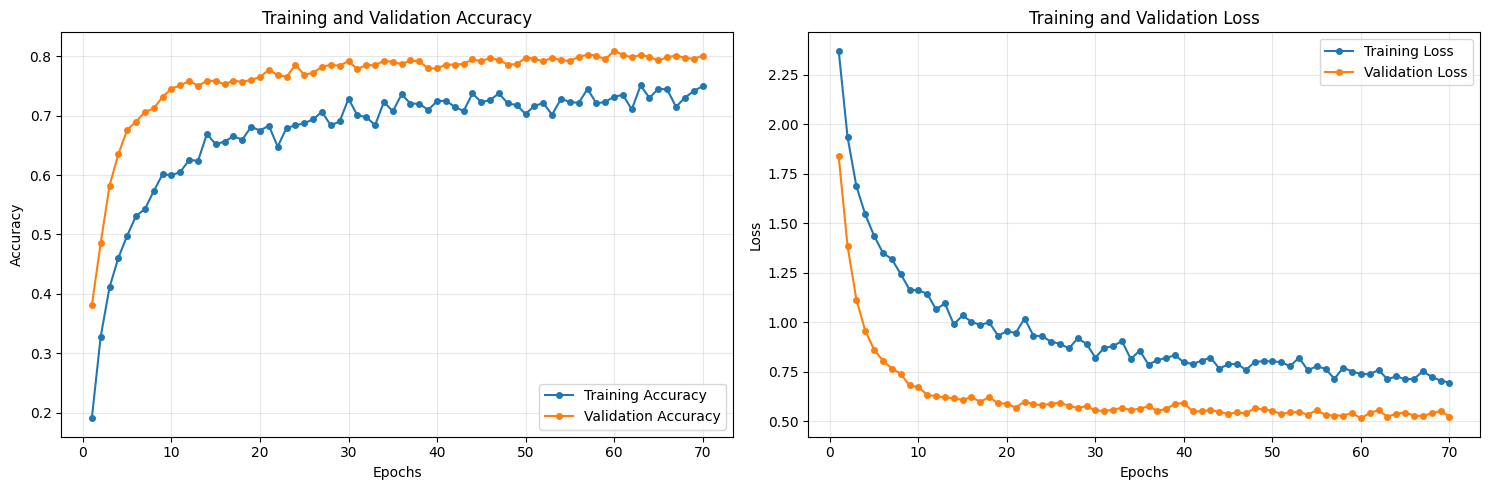

In [ ]:
def plot_training_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # 1. Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o', markersize=4)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', markersize=4)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # 2. Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', markersize=4)
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', markersize=4)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Panggil fungsi plot dengan variabel history Anda
print("Menampilkan Grafik Training...")
plot_training_history(history)

🔍 Sedang mengevaluasi data validasi...


100%|██████████| 54/54 [00:06<00:00,  8.93it/s]



📑 LAPORAN PERFORMA PER SPESIES:
                                              precision    recall  f1-score   support

                  Anas platyrhynchos_Mallard       0.76      0.90      0.83        82
           Bubo virginianus_Great Horned Owl       0.85      0.74      0.79        39
            Cistothorus palustris_Marsh Wren       0.84      0.77      0.80        48
                 Corvus corax_Northern Raven       0.90      0.95      0.93       178
                Cyanocitta cristata_Blue Jay       0.78      0.75      0.77        48
         Dumetella carolinensis_Grey Catbird       0.67      0.66      0.67        47
      Geothlypis trichas_Common Yellowthroat       0.80      0.71      0.75        62
            Haemorhous mexicanus_House Finch       0.83      0.50      0.62        38
                Hirundo rustica_Barn Swallow       0.78      0.87      0.82       122
              Junco hyemalis_Dark-eyed Junco       0.65      0.79      0.71        52
             Passer 

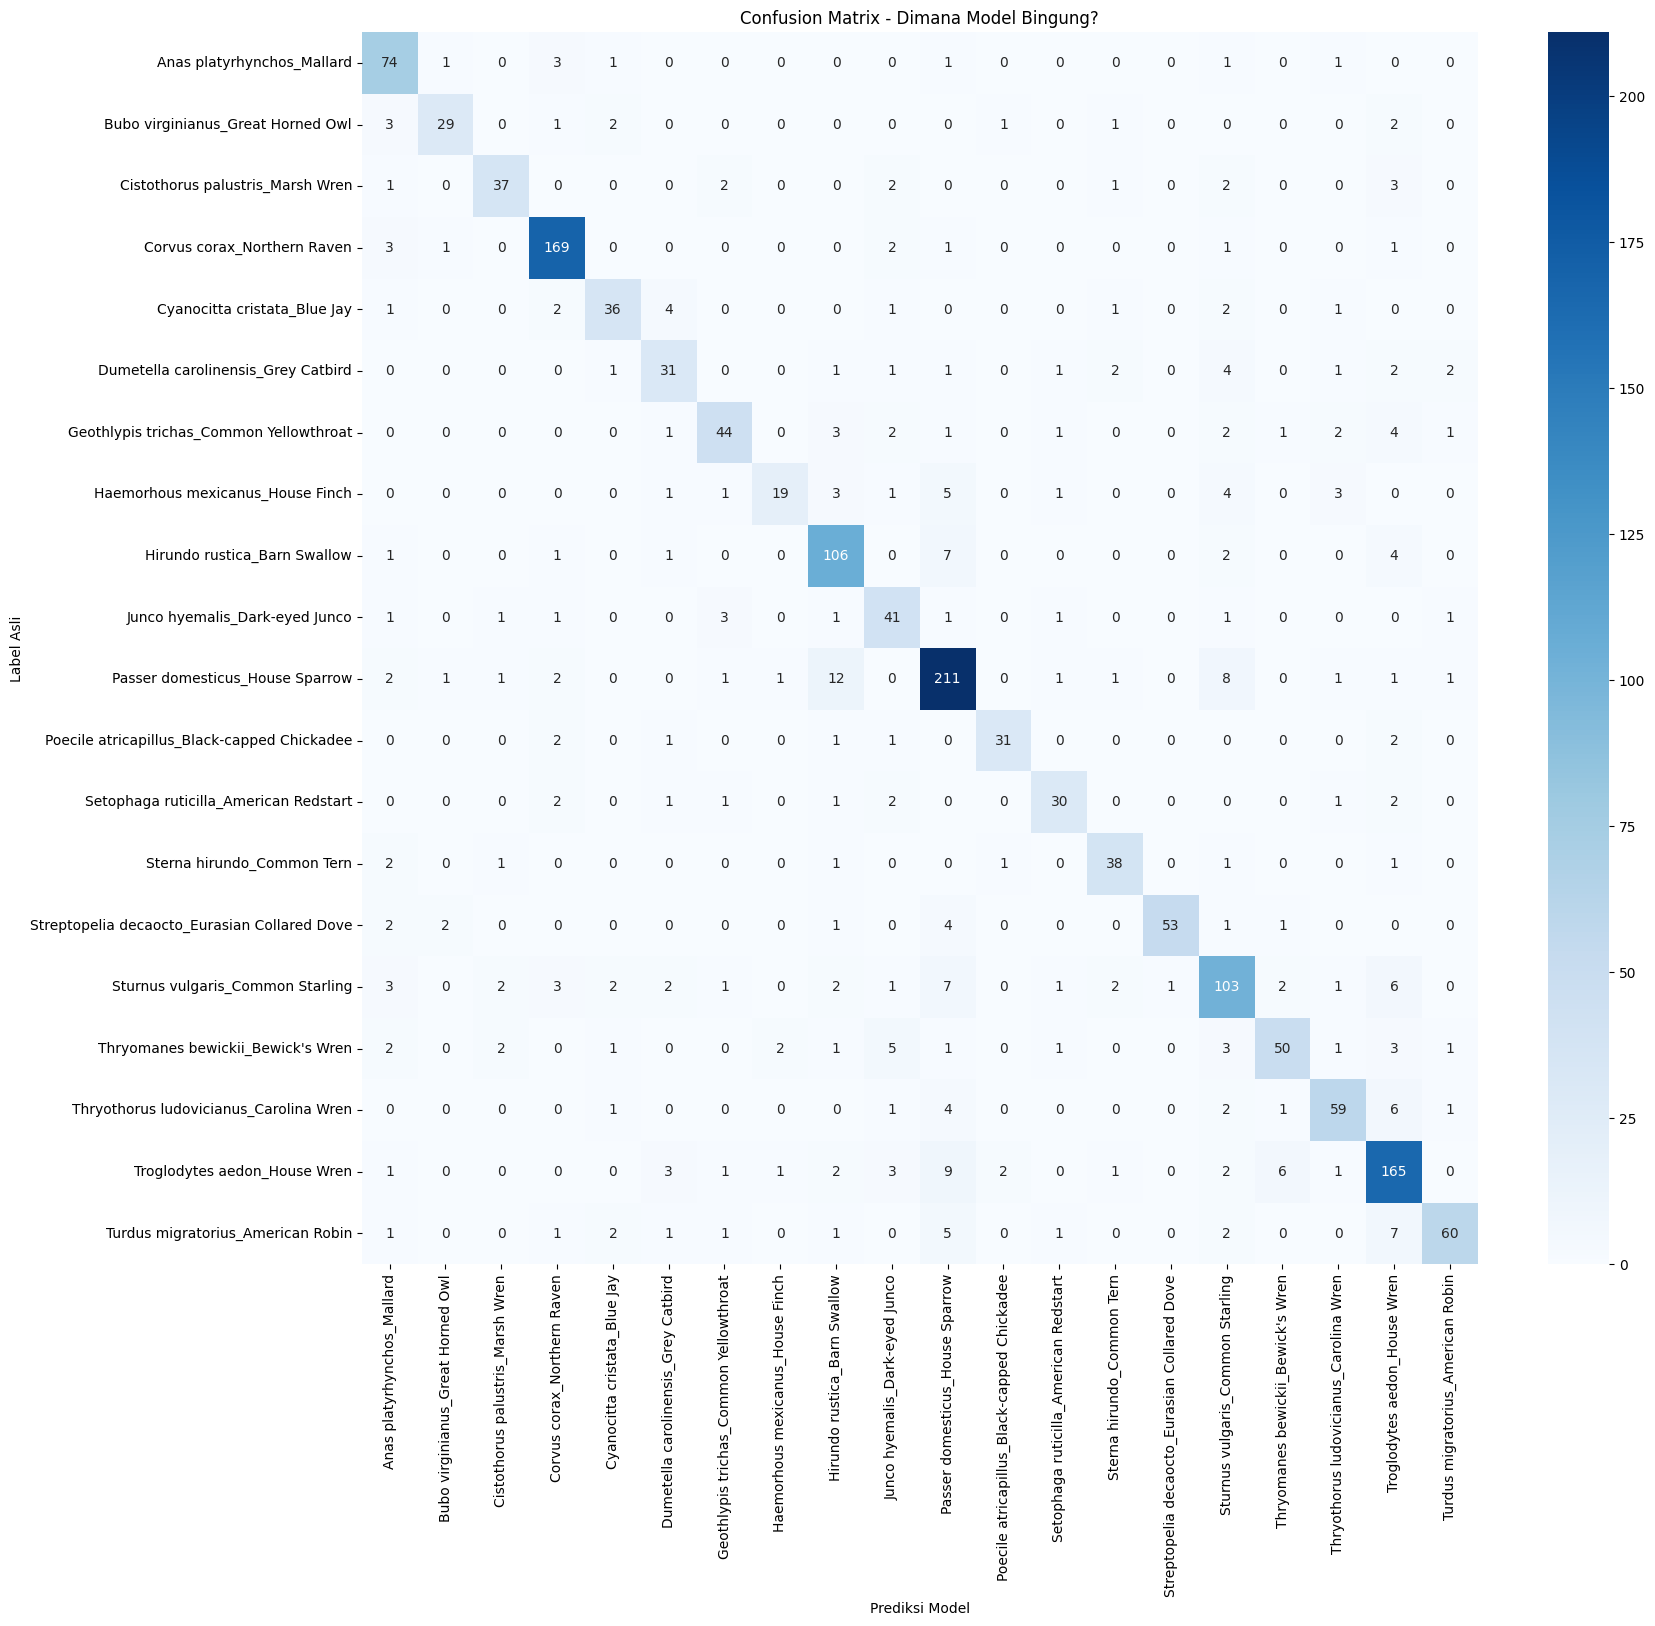

In [ ]:
model.eval()
y_true = []
y_pred = []

print("Sedang mengevaluasi data validasi...")
with torch.no_grad():
    for inputs, labels in tqdm(dataloaders['val']):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = image_datasets['val'].classes

print("\nLAPORAN PERFORMA PER SPESIES:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(18, 16))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.title('Confusion Matrix - Dimana Model Bingung?')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
TEST_DIR = os.path.join(DATA_DIR, 'val') 

print(f"Menguji data dari: {TEST_DIR}")

# Siapkan Dataloader Khusus Test
test_data = datasets.ImageFolder(TEST_DIR, data_transforms['val'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

def hitung_akurasi(model, dataloader):
    model.eval() # Mode evaluasi
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    acc = 100 * correct / total
    return acc, correct, total

final_acc, jumlah_benar, jumlah_total = hitung_akurasi(model, test_loader)

print("-" * 30)
print(f"HASIL AKHIR:")
print(f"Benar: {jumlah_benar} dari {jumlah_total} gambar")
print(f"Accuracy: {final_acc:.2f}%")
print("-" * 30)

Menguji data dari: dataset_for_training\val


100%|██████████| 54/54 [00:06<00:00,  8.82it/s]

------------------------------
HASIL AKHIR:
Benar: 1386 dari 1713 gambar
Accuracy: 80.91%
------------------------------


Menampilkan prediksi dari 9 spesies berbeda...


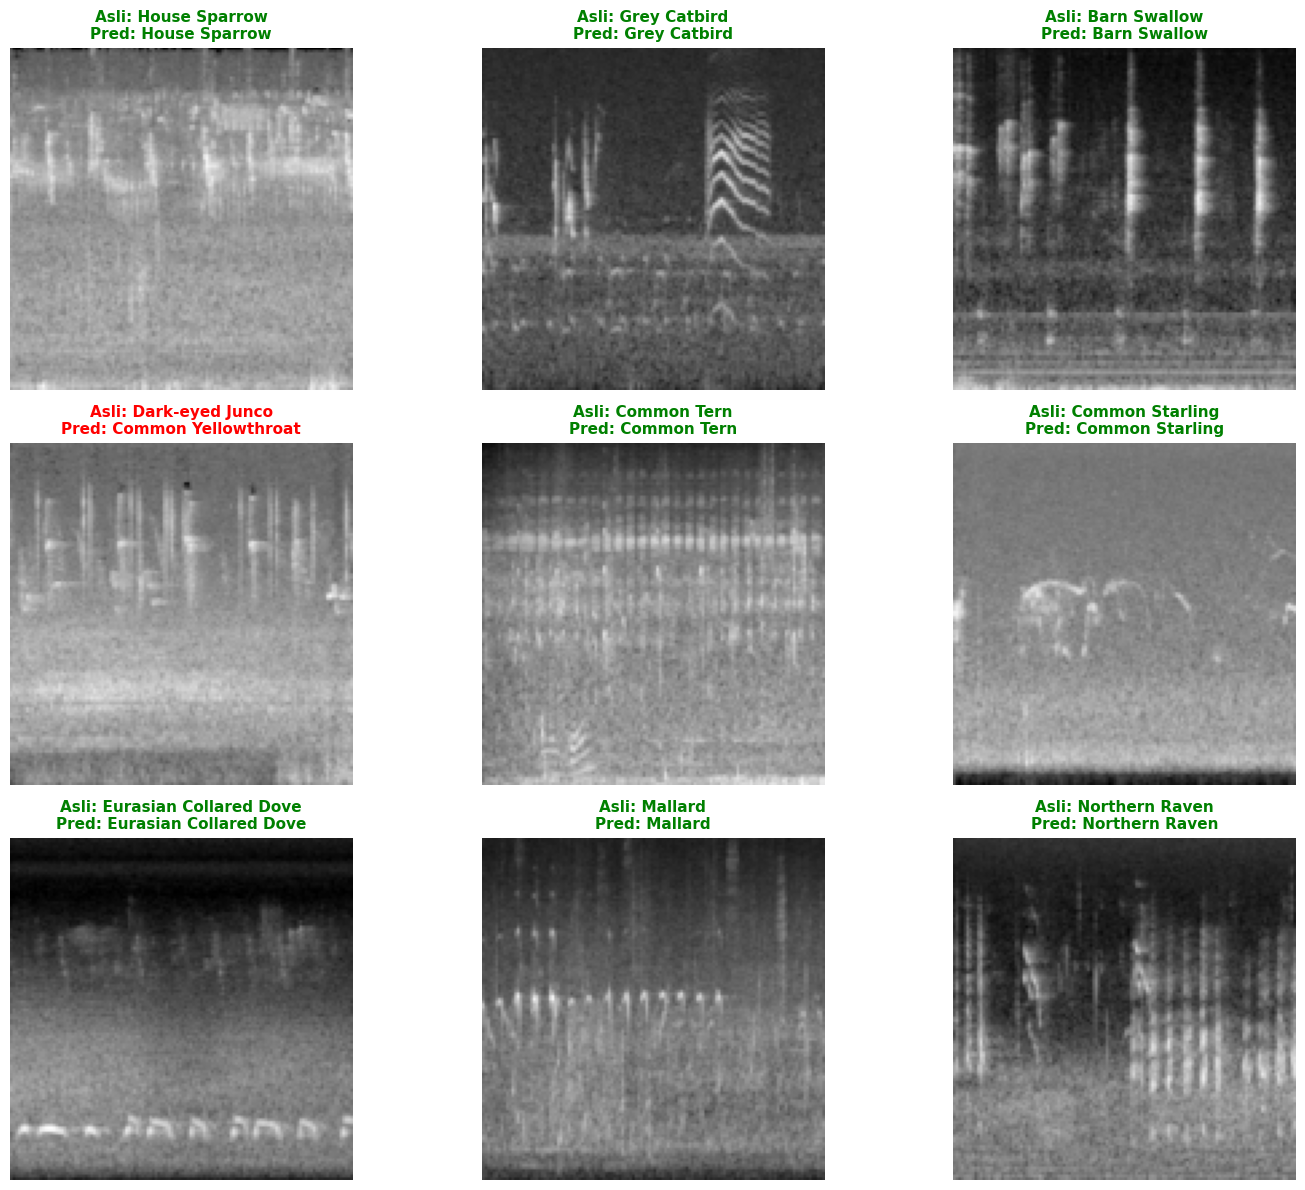

In [ ]:
def visual_test_unique(model, dataloader, num_images=9):
    was_training = model.training
    model.eval()
    
    images_so_far = 0
    displayed_classes = set()
    
    plt.figure(figsize=(15, 12))

    with torch.no_grad():
        # Loop semua batch di dataloader
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Loop setiap gambar dalam batch
            for j in range(inputs.size(0)):
                
                label_idx = labels[j].item()
                
                # Jika kelas ini SUDAH pernah ditampilkan, SKIP (lanjut ke gambar berikutnya)
                if label_idx in displayed_classes:
                    continue
                
                # Jika belum, catat kelas ini agar tidak muncul lagi
                displayed_classes.add(label_idx)
                
                images_so_far += 1
                ax = plt.subplot(3, 3, images_so_far)
                ax.axis('off')
                
                # Un-normalize
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                
                label_asli = class_names[labels[j]]
                label_pred = class_names[preds[j]]
                
                warna = 'green' if label_asli == label_pred else 'red'
                
                nama_asli_short = label_asli.split('_')[-1]
                nama_pred_short = label_pred.split('_')[-1]
                
                ax.imshow(inp)
                ax.set_title(f"Asli: {nama_asli_short}\nPred: {nama_pred_short}", color=warna, fontsize=11, fontweight='bold')

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

        model.train(mode=was_training)

# buat loader sementara yang shuffle=True agar urutan burungnya acak
test_loader_shuffle = torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=True)

print("Menampilkan prediksi dari 9 spesies berbeda...")
visual_test_unique(model, test_loader_shuffle, num_images=9)